In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from material_models import GOH_fullyinc
from misc import preprocessing, normalization, predict
import tensorflow as tf
import pickle
import pandas as pd
import tensorflow.keras.backend as K

## Inputs

In [2]:
data  = 'S112S2_xyb'
theta = 15
limits = {'S111S1_xyb':[0, 183, 2*183, 3*183], 'S111S4_xyb':[0, 184, 367, 3*183], 'S112S2_xyb':[0, 184, 367, 3*183], 
          'S112S3_xyb':[0, 183, 366, 3*183], 'S112S4_xyb':[0, 184, 367, 3*183], 'S113S3_xyb':[0, 183, 366, 3*183],
          'S113S4_xyb':[0, 183, 366, 3*183], 'S143S1_xyb':[0, 62, 121, 3*183], 'S143S2_xyb':[0, 62, 123, 3*183],
          'S144S3_xyb':[0, 62, 123, 3*183], 'S144S4_xyb':[0, 62, 123, 3*183]
         }
lim = limits[data]

## Generate line plot data

In [3]:
models = ['S112S2_xy', 'S112S2_xys']
model = models[0]
ndata, I1, I2, I4a, I4s, Psi_gt, lm_gt, Y, sigma_gt_sf, F, C, C_inv  = preprocessing(data, theta1=theta)
sigma_pr_sf_conv, _, _, _, _, _ = predict(model, data, theta1=theta)
sigma_pr_sf_ncon, _, _, _, _, _ = predict(model, data, impose_convexity=False, theta1=theta)

model = models[1]
ndata, I1, I2, I4a, I4s, Psi_gt, lm_gt, Y, sigma_gt_mf, F, C, C_inv  = preprocessing(data, theta1=theta)
sigma_pr_mf_conv, _, _, _, _, _ = predict(model, data, theta1 = theta)
sigma_pr_mf_ncon, _, _, _, _, _ = predict(model, data, impose_convexity=False, theta1=theta)

## Calculate Errors

In [4]:
errors = []
preds = [sigma_pr_sf_ncon, sigma_pr_sf_conv, sigma_pr_mf_ncon, sigma_pr_mf_conv]
gts = [sigma_gt_sf, sigma_gt_sf, sigma_gt_mf, sigma_gt_mf]
for sigma_pr, sigma_gt in zip(preds, gts):
    error = np.zeros(sigma_gt.shape[0])
    for i in range(sigma_gt.shape[0]):
        for j in range(3):
            for k in range(3):
                error[i]+= (sigma_gt[i,k,j] - sigma_pr[i,k,j])**2
        error[i] = np.sqrt(error[i])
    error = error*1000 #MPa -> kPa
    offx_error = np.mean(error[:lim[1]])
    offy_error = np.mean(error[lim[1]:lim[2]])
    equi_error = np.mean(error[lim[2]:lim[3]])
    errors.append([offx_error, offy_error, equi_error])
errors

[[4.56334571600276, 5.25139362841715, 7.334702867421058],
 [7.367739221206278, 5.800697139405719, 12.554887781105876],
 [5.933437623800476, 5.755136133651452, 11.754441819461348],
 [8.2137680326853, 7.27015508008649, 11.469985786861246]]

## Generate contour data

In [5]:
models = ['S112S2_xy', 'S112S2_xys']
for model_name in models:
    for impose_convexity in range(2): #this will return 0=False and 1=True
        dataset_name = 'contour_dataset'
        ndata, I1, I2, I4a, I4s, Psi_gt, X, Y, sigma_gt, F, C, C_inv  = preprocessing(dataset_name)
        meanPsi, meanI1, meanI2, meanI4a, meanI4s, stdPsi, stdI1, stdI2, stdI4a, stdI4s = normalization(True, model_name, Psi_gt, I1, I2, I4a, I4s)

        Psinorm = (Psi_gt - meanPsi)/stdPsi
        I1norm  = (I1     - meanI1) /stdI1
        I2norm  = (I2     - meanI2) /stdI2
        I4anorm = (I4a    - meanI4a)/stdI4a
        I4snorm = (I4s    - meanI4s)/stdI4s

        #### Combine the NN inputs
        inputs = np.array([I1norm, I2norm, I4anorm, I4snorm]).transpose()
        inpten = tf.Variable(inputs)

        #Load the model
        if impose_convexity == True:
            model_fname   = 'savednet/' + model_name + '.json'
            weights_fname = 'savednet/' + model_name + '_weights.h5'
        else:
            model_fname   = 'savednet/' + model_name + '_nonconv.json'
            weights_fname = 'savednet/' + model_name + '_nonconv_weights.h5'
        model = tf.keras.models.model_from_json(open(model_fname).read())
        model.load_weights(weights_fname)
        

        #Make predictions
        with tf.GradientTape(persistent=True) as t:
            y_pred = model(inpten)
            if impose_convexity == True:
                Psi1  = y_pred[:,1]**2*stdPsi/stdI1
                Psi2  = y_pred[:,2]**2*stdPsi/stdI2
                Psi4a = y_pred[:,3]**2*stdPsi/stdI4a
                Psi4s = y_pred[:,4]**2*stdPsi/stdI4s
            else:
                Psi1  = y_pred[:,1]*stdPsi/stdI1
                Psi2  = y_pred[:,2]*stdPsi/stdI2
                Psi4a = y_pred[:,3]*stdPsi/stdI4a
                Psi4s = y_pred[:,4]*stdPsi/stdI4s

        gradPsi1  = t.gradient(Psi1,inpten)
        gradPsi2  = t.gradient(Psi2,inpten)
        gradPsi4a = t.gradient(Psi4a,inpten)
        gradPsi4s = t.gradient(Psi4s,inpten)
        
        dI1dI1    = gradPsi1[:,0] #d^2Psi/d^2I1
        dI1dI2    = gradPsi1[:,1] #d^2Psi/dI1dI2
        dI2dI2    = gradPsi2[:,1]

        #Symmetry Loss
        sym = K.abs(gradPsi1[:,1]  - gradPsi2[:,0] ) #dPsidI1dI2 - dPsidI2dI1
        sym+= K.abs(gradPsi1[:,2]  - gradPsi4a[:,0])
        sym+= K.abs(gradPsi1[:,3]  - gradPsi4s[:,0])
        sym+= K.abs(gradPsi2[:,2]  - gradPsi4a[:,1])
        sym+= K.abs(gradPsi2[:,3]  - gradPsi4s[:,1])
        sym+= K.abs(gradPsi4a[:,3] - gradPsi4s[:,2])

        #Convexity Loss
        #Leading Principal Minors, LPM
        matrix1 = [gradPsi1[:,:3], gradPsi2[:,:3], gradPsi4a[:,:3]] #Hessian matrix minus the last row and column
        matrix1 = tf.stack(matrix1)
        matrix1 = tf.transpose(matrix1, perm=[1,0,2])

        matrix2 = [gradPsi1, gradPsi2, gradPsi4a, gradPsi4s] #Hessian matrix
        matrix2 = tf.stack(matrix2)
        matrix2 = tf.transpose(matrix2, perm=[1,0,2])

        LPM1 = dI1dI1
        LPM2 = dI1dI1*dI2dI2 - dI1dI2*dI1dI2
        LPM3 = tf.linalg.det(matrix1)
        LPM4 = tf.linalg.det(matrix2)

        zeros = tf.zeros_like(LPM1)
        conv = K.max((-LPM1[:], zeros),axis=0)
        conv+= K.max((-LPM2[:], zeros),axis=0)
        conv+= K.max((-LPM3[:], zeros),axis=0)
        conv+= K.max((-LPM4[:], zeros),axis=0)

        gridsize = 20
        meshsize = gridsize**2
        X        = np.zeros([meshsize,2])
        lm1      = np.linspace(1.,1.25,gridsize)
        lm2      = np.linspace(1.,1.25,gridsize)
        lm1, lm2 = np.meshgrid(lm1,lm2)

        convexity_loss = sym + conv
        convexity_loss = convexity_loss.numpy().reshape([gridsize,gridsize])

        convexity = ['nonconvex', 'convex'][impose_convexity]
        with open('training_data/'+model_name+'_' + convexity + '_contour.npy', 'wb') as f:
            np.save(f,[lm1, lm2, convexity_loss])  

## Murine figure

<ipython-input-6-fd6047b526f0>:30: UserWarning: No contour levels were found within the data range.
  ax4.contour(lm1, lm2, convexity_loss, colors='k', levels = levels)


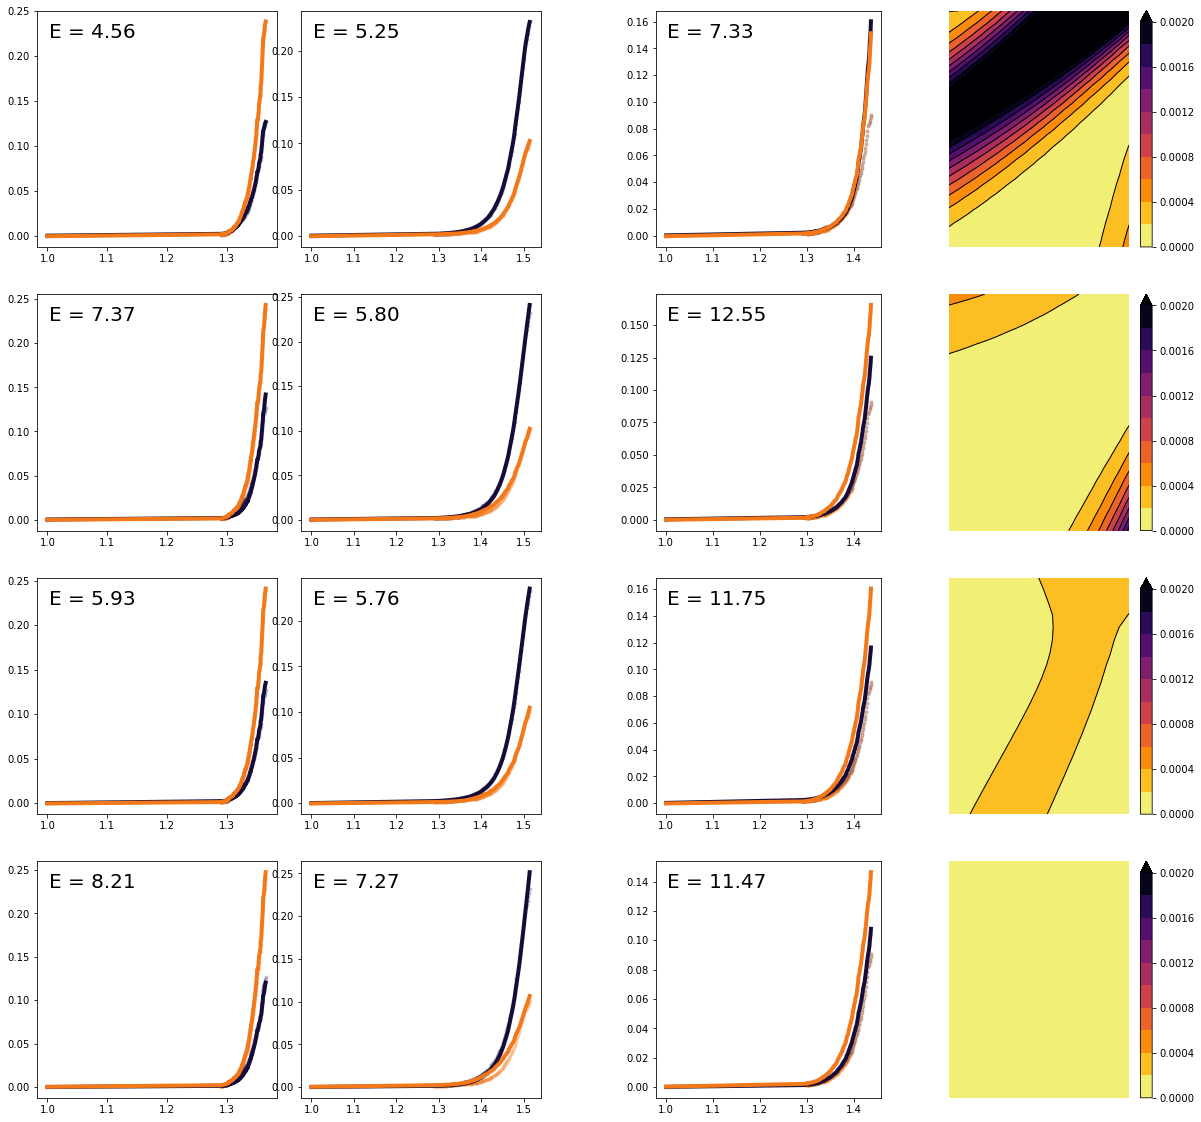

In [6]:
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0.1, 0.7, 2)))
fig = plt.figure(figsize=(20,20))
gs1 = fig.add_gridspec(4,2, wspace=0.1, hspace=0.2, left = 0.05, right = 0.4)
gs2 = fig.add_gridspec(4,2, wspace=0.3, hspace=0.2, left = 0.48, right = 0.84)

models = ['S112S2_xy_nonconvex','S112S2_xy_convex','S112S2_xys_nonconvex','S112S2_xys_convex']
for i, (sigma_pr, sigma_gt, model) in enumerate(zip(preds, gts, models)):
    pltparams = {'lines.linewidth': 4,}
    plt.rcParams.update(pltparams)
    ax1 = fig.add_subplot(gs1[i,0])
    ax2 = fig.add_subplot(gs1[i,1])
    ax3 = fig.add_subplot(gs2[i,0])
    ax4 = fig.add_subplot(gs2[i,1])
    for j, ax in enumerate([ax1, ax2, ax3]):
        i1 = lim[j]
        i2 = lim[j+1]
        ax.plot(lm_gt[i1:i2,0], sigma_gt[i1:i2,0,0],'.',alpha=0.2)
        ax.plot(lm_gt[i1:i2,0], sigma_gt[i1:i2,1,1],'.',alpha=0.2)
        ax.plot(lm_gt[i1:i2,0], sigma_pr[i1:i2,0,0])
        ax.plot(lm_gt[i1:i2,0], sigma_pr[i1:i2,1,1])
        mystr = 'E = {s:.2f}'.format(s=errors[i][j])
        ax.text(0.05,0.95, mystr, transform=ax.transAxes, va='top', fontsize=20)
        

    pltparams = {'lines.linewidth': 1,}
    plt.rcParams.update(pltparams)
    with open('training_data/'+model+'_contour.npy', 'rb') as f:
        lm1, lm2, convexity_loss = np.load(f)
    levels = np.linspace(0, 0.002, 11) 
    ax4.contour(lm1, lm2, convexity_loss, colors='k', levels = levels)
    cntr1 = ax4.contourf(lm1, lm2, convexity_loss, cmap="inferno_r", levels = levels, vmin = 0, vmax = levels[-1], extend='max')
    ax4.axis('off')
    fig.colorbar(cntr1, ax=ax4)
fig.savefig('figs/fig_murine.jpg', bbox_inches='tight')

## Save pgfplots data

#### Line plots data

In [7]:
preds = [sigma_pr_sf_ncon, sigma_pr_sf_conv, sigma_pr_mf_ncon, sigma_pr_mf_conv]
gts = [sigma_gt_sf, sigma_gt_sf, sigma_gt_mf, sigma_gt_mf]
labels_list = [['A', 'B', 'C'], ['E', 'F', 'G'], ['I', 'J', 'K'], ['M', 'N', 'O']]
for labels, sigma_pr, sigma_gt in zip(labels_list, preds, gts):
    for i, label in enumerate(labels):
        i1 = lim[i]
        i2 = lim[i+1]
        x = lm_gt[i1:i2,0]
        y_pr_x = sigma_pr[i1:i2,0,0]*1000
        y_pr_y = sigma_pr[i1:i2,1,1]*1000
        y_gt_x = sigma_gt[i1:i2,0,0]*1000
        y_gt_y = sigma_gt[i1:i2,1,1]*1000
        data = np.stack([x, y_pr_x, y_pr_y, y_gt_x, y_gt_y])
        header = ['x', 'prx', 'pry', 'gtx', 'gty']
        df = pd.DataFrame(data.T, columns=header)
        df.to_csv('tikz_data/fig_murine_data/fig_murine_'+label+'.csv', index=False, sep=' ')

#### Contour figures

<ipython-input-9-b3f7cb42ef7f>:27: UserWarning: No contour levels were found within the data range.
  ax.contour(lm1, lm2, convexity_loss, colors='k', levels = levels)


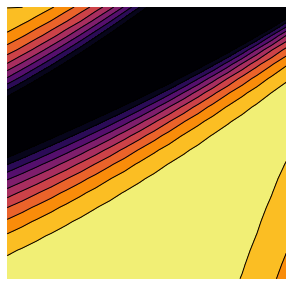

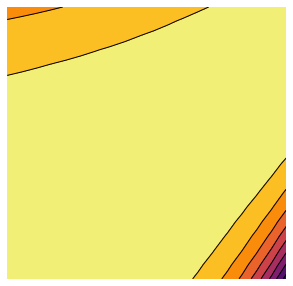

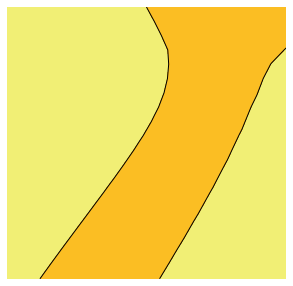

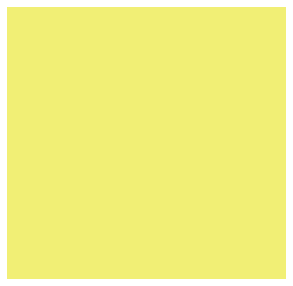

In [9]:
fsize=5
pltparams = {'legend.fontsize': 'large',
          'figure.figsize': (fsize,fsize),
          'font.size'     : 4*fsize,
          'axes.labelsize': 10*fsize,
          'axes.titlesize': 10*fsize,
          'xtick.labelsize': 0,
          'ytick.labelsize': 3.5*fsize,
          'lines.linewidth': 1,
          'lines.markersize': 10,
          'lines.markeredgewidth': 2,
          'axes.titlepad': 0,
          "mathtext.fontset": 'dejavuserif',
          'axes.labelpad': 0}
plt.rcParams.update(pltparams)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0.1, 0.7, 2)))

models = ['S112S2_xy_nonconvex','S112S2_xy_convex','S112S2_xys_nonconvex','S112S2_xys_convex']
labels = ['D', 'H', 'L', 'P']
for model, label in zip(models, labels):
    fig = plt.figure()
    gs = fig.add_gridspec(1,1) #nrows, ncols
    with open('training_data/'+model+'_contour.npy', 'rb') as f:
        lm1, lm2, convexity_loss = np.load(f)
    ax = fig.add_subplot(gs[0, 0])
    levels = np.linspace(0, 0.002, 11) 
    ax.contour(lm1, lm2, convexity_loss, colors='k', levels = levels)
    cntr1 = ax.contourf(lm1, lm2, convexity_loss, cmap="inferno_r", levels = levels, vmin = 0, vmax = levels[-1], extend='max')
    ax.axis('off')
    # fig.colorbar(cntr1, ax=ax)
    fig.savefig('tikz_data/fig_murine_data/fig_murine_'+label+'.jpg', bbox_inches='tight', pad_inches=0.0)